In [1]:
import pandas as pd
import xgboost as xgb
from xgboost import XGBClassifier
import numpy as np
import sklearn as sk
import datetime as dt
from sklearn import model_selection
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from sklearn.metrics import confusion_matrix, mean_squared_error, auc, accuracy_score, log_loss
import os

In [2]:
# suppress warnings
import warnings
warnings.filterwarnings('ignore')

#set display options
pd.set_option('max_columns', 150)
pd.set_option('max_rows', 110)
pd.set_option('display.mpl_style', 'default')
pd.set_option('display.notebook_repr_html', True)

In [3]:
#set input/output paths
#can eventually set this to the SOAPY API https://dev.socrata.com/foundry/data.waterpointdata.org/gihr-buz6
#DATA_PATH = "~chandlermccann/Downloads/"
DATA_PATH = "/Users/chandlermccann/Google Drive/Google Drive/Berkeley MIDS 2016/W210-Capstone_WaterProject"
INPUT_FILE = os.path.join(DATA_PATH, "cleaned_water_data2.csv") #after running prep_water_data.py


In [4]:
df= pd.read_csv(INPUT_FILE, encoding='latin-1')
#df.drop(['Row ID'], axis=1, inplace=True)
df.head()

,country_name,water_source,water_tech,status_id,management,pay,installer,install_year,status,source,adm1,adm2,wpdx_id,report_date,country_id,activity_id,data_lnk,orig_lnk,photo_lnk,converted,created,updated,lat_deg,lon_deg,Location,Count,fecal_coliform_presence,fecal_coliform_value,subjective_quality,new_report_date,new_install_year,age_well,age_well_days,status_binary,time_since_measurement,time_since_meas_years,age_well_years,fuzzy_water_source,fuzzy_water_tech
0,"Tanzania, United Republic of",Spring,Gravity Communal standpipe,no,__MISSING__,Never pay,RWE,1972.0,Status:Not functional|Quantity:Dry|Quality:Soft,SNV,Arusha,Longido,wpdx-00000001,01/05/2008 12:00:00 AM +0000,TZ,__MISSING__,http://www.dropbox.com/s/50779gal9v4z4y6/TZ%20...,__MISSING__,__MISSING__,"""#water_tech, #country_id, #data_lnk""",10/23/2015 01:03:07 AM +0000,10/23/2015 01:03:07 AM +0000,-2.83257,36.3090,"(-2.83257, 36.309)",1,NaN,NaN,NaN,2008-01-05,1972-01-01 00:00:00,13153 days 00:00:00.000000000,13153,1,3710 days 00:00:00.000000000,10.2,36.0,Spring River Stream Protected,Gravity
1,"Tanzania, United Republic of",Rainwater harvesting,Gravity Communal standpipe,yes,__MISSING__,Never pay,World Vision,2005.0,Status:Functional|Breakdown Year:2007|Reason N...,SNV,Arusha,Longido,wpdx-00000002,01/01/2008 12:00:00 AM +0000,TZ,__MISSING__,http://www.dropbox.com/s/50779gal9v4z4y6/TZ%20...,__MISSING__,__MISSING__,"""#water_tech, #country_id, #data_lnk""",10/23/2015 01:03:07 AM +0000,10/23/2015 01:03:07 AM +0000,-2.84781,36.5284,"(-2.84781, 36.5284)",1,NaN,NaN,NaN,2008-01-01,2005-01-01 00:00:00,1095 days 00:00:00.000000000,1095,0,3714 days 00:00:00.000000000,10.2,3.0,Rain Rainwater,Gravity
2,"Tanzania, United Republic of",Rainwater harvesting,Gravity Communal standpipe,yes,__MISSING__,Never pay,World Vision,2005.0,Status:Functional|Quantity:Seasonal|Quality:Soft,SNV,Arusha,Longido,wpdx-00000003,01/01/2008 12:00:00 AM +0000,TZ,__MISSING__,http://www.dropbox.com/s/50779gal9v4z4y6/TZ%20...,__MISSING__,__MISSING__,"""#water_tech, #country_id, #data_lnk""",10/23/2015 01:03:07 AM +0000,10/23/2015 01:03:07 AM +0000,-2.84796,36.5288,"(-2.84796, 36.5288)",1,NaN,NaN,NaN,2008-01-01,2005-01-01 00:00:00,1095 days 00:00:00.000000000,1095,0,3714 days 00:00:00.000000000,10.2,3.0,Rain Rainwater,Gravity
3,"Tanzania, United Republic of",Rainwater harvesting,Gravity Communal standpipe,yes,__MISSING__,Never pay,World Vision,2005.0,Status:Functional|Quantity:Seasonal|Quality:Soft,SNV,Arusha,Longido,wpdx-00000004,01/01/2008 12:00:00 AM +0000,TZ,__MISSING__,http://www.dropbox.com/s/50779gal9v4z4y6/TZ%20...,__MISSING__,__MISSING__,"""#water_tech, #country_id, #data_lnk""",10/23/2015 01:03:07 AM +0000,10/23/2015 01:03:07 AM +0000,-2.85318,36.5276,"(-2.85318, 36.5276)",1,NaN,NaN,NaN,2008-01-01,2005-01-01 00:00:00,1095 days 00:00:00.000000000,1095,0,3714 days 00:00:00.000000000,10.2,3.0,Rain Rainwater,Gravity
4,Nicaragua,__MISSING__,__MISSING__,yes,__MISSING__,__MISSING__,__MISSING__,2011.0,__MISSING__,El Porvenier,Matagalpa,Terrabona,wpdx-00000005,01/01/2011 12:00:00 AM +0000,NI,__MISSING__,http://www.dropbox.com/s/0f70mln5roxhy29/ProjT...,https://www.waterpointdata.org/dataset/resourc...,__MISSING__,"#data_lnk, #lon_deg, #lat_deg, #country_id",04/08/2016 08:35:49 AM +0000,04/08/2016 08:35:49 AM +0000,12.74070,-86.0121,"(12.7407, -86.0121)",1,NaN,NaN,NaN,2011-01-01,2011-01-01 00:00:00,0 days 00:00:00.000000000,0,0,2618 days 00:00:00.000000000,7.2,0.0,__MISSING__ Unknown,__MISSING__


In [ ]:
df.describe()

In [5]:
# define countries that are 80% of all data points
countries_for_preds = ['Afghanistan', 'Sierra Leone', 'Swaziland', 'Zimbabwe', 'Kenya', 'Liberia', 'Malawi', 'South Sudan', 
'Uganda','India']

In [6]:
#investigate how long it's been since they've been measured
df.loc[(df['country_name'].isin(countries_for_preds) )].groupby('country_name')\
.time_since_meas_years.agg(['min','mean','max','std'])\
.sort_values(by='mean', ascending=False)

,min,mean,max,std
country_name,,,,
South Sudan,1.2,10.386876,44.8,7.326900
Afghanistan,3.7,7.591604,17.9,4.445632
Uganda,0.1,7.376757,26.3,1.711029
Liberia,0.9,5.660528,38.2,2.327874
Kenya,0.1,4.225987,28.0,1.210975
Sierra Leone,1.2,3.852758,6.2,2.274419
Malawi,0.1,3.817732,33.9,4.093122
Swaziland,2.6,3.446670,30.1,0.619703
India,1.4,2.264872,18.2,0.705699


# Afghanistan, South Sudan and Uganda have the longest average time since their last report date on their wells

# create dataframes of all the countries we want to measure

In [7]:
#create a dictionary to store all of the dataframes in for each country level model with the country name as the key
#only for the countries we are evaluating
df_dict = {}
for name in df.loc[(df['country_name'].isin(countries_for_preds) )].country_name.unique():
    #print(name)
    df_dict[name] = df[df.country_name== name]

In [37]:
for k in countries_for_preds:
    print(k,"num unique water sources: ",len(df_dict[k].water_source.unique()), "num unique water techs: ", len(df_dict[k].water_tech.unique()))

Afghanistan num unique water sources:  8 num unique water techs:  9
Sierra Leone num unique water sources:  103 num unique water techs:  185
Swaziland num unique water sources:  14 num unique water techs:  16
Zimbabwe num unique water sources:  32 num unique water techs:  19
Kenya num unique water sources:  78 num unique water techs:  217
Liberia num unique water sources:  16 num unique water techs:  126
Malawi num unique water sources:  62 num unique water techs:  52
South Sudan num unique water sources:  6 num unique water techs:  15
Uganda num unique water sources:  58 num unique water techs:  106
India num unique water sources:  1 num unique water techs:  16


In [39]:
# based on the small number of levels above, I don't think fuzzy matching will help Afg, Swaz, 
#Zimbabwe, South Sudan. We'll see

# try this one piece at a time

In [33]:
#1) Copy DF and take pred cols
#2) label encode df
#3) Split into X and Y
#4) Label encode X and Y
#5) Split in to train, test (Currently label encoded. Label encoding expects specific columns so can't append anything yet)
#6) Run model and predict. Store predictions.
#6a)Y_train and Test keep the indices from train/test split, we can use these to merge back to the original dataframe
#7) Store the actual values of y_test, predictions from X_test, Probabilities from predictions from X_Test in a dataframe
# This will keep the indices of the original data set
#repeat for Y_train
#9) Merge our actual values, predicted class and probabilities back into the parent data frame

In [9]:
#try for just swaziland
df2 = df_dict['Swaziland'].copy()

#only keep prediction columns, and in our fuzzy matched ones
pred_cols = ['water_source', 'water_tech', 'management',
   'source', 'adm1', 'adm2', 'pay', 'lat_deg', 'lon_deg',
   'new_install_year', 'age_well_years','time_since_meas_years', 'fuzzy_water_source',
    'fuzzy_water_tech','status_binary']

df2=df2[pred_cols]

#convert all fields to int labels for XGBoost
lb=LabelEncoder() #instantiate label encoder

#create a dict to store our inverse transforms...these allow us to convert back to the original values in our data
from collections import defaultdict
d = defaultdict(LabelEncoder)

# Encoding each variable
fit = df2.apply(lambda x: d[x.name].fit_transform(x))

In [10]:
#define features and target columns
X = fit[fit.columns[:-1]] 
Y= fit.status_binary

#Create 50% test sets, 50% training, stratifying on Y.
#We we will train and make predictions on the other half, then switch
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, Y,  test_size=.5, random_state=7, stratify=Y)

In [11]:
#use stratified K folds and gridsearch..ON THE TRAINING DATA
params = {'learning_rate':[0.05,.1], 'max_depth':[3,4], 'n_estimators':[200,300],}
modelA = model_selection.GridSearchCV(XGBClassifier(scoring='logloss'), params)
modelA.fit(X_train, y_train )
print('model fit for first 50% of', df_dict['Swaziland'].country_name.unique())
print('Shape of input params= ', X_train.shape)
print(modelA.best_params_)
#print(model2.grid_scores_)
print(modelA.best_score_)


#get auc. need to reshape
predsA_AUC = modelA.predict_proba(X_test)[:,1]
predsA_accuracy = modelA.predict(X_test)
print("Accuracy for modelA : %.4g"%metrics.accuracy_score(y_test, predsA_accuracy))
print("AUC Score (test) for modelA: %f"%metrics.roc_auc_score(y_test, predsA_AUC))

model fit for first 50% of ['Swaziland']
Shape of input params=  (11892, 14)
{'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 300}
0.972838883283
Accuracy for modelA : 0.9735
AUC Score (test) for modelA: 0.993499


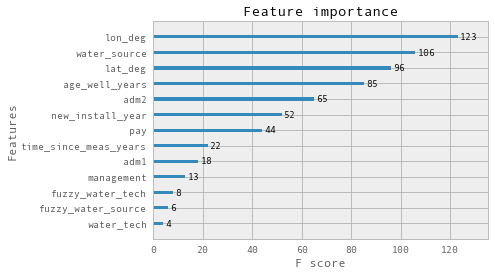

In [34]:
#retrain with best params for feature importances
best_modelA = XGBClassifier(params= modelA.best_params_)
#refit
best_modelA.fit(X_train, y_train)
xgb.plot_importance(best_modelA)

In [12]:
 #use stratified K folds and gridsearch..ON THE TRAINING DATA
params = {'learning_rate':[0.05,.1], 'max_depth':[3,4], 'n_estimators':[200,300],}
modelB = model_selection.GridSearchCV(XGBClassifier(scoring='logloss'), params)
modelB.fit(X_test, y_test )
print('model fit for second 50% of', df_dict['Swaziland'].country_name.unique())
print('Shape of input params= ', X_test.shape)
print(modelB.best_params_)
#print(model2.grid_scores_)
print(modelB.best_score_)


#get auc. need to reshape
predsB_AUC = modelB.predict_proba(X_train)[:,1]
predsB_accuracy = modelB.predict(X_train)
print("Accuracy for modelB : %.4g"%metrics.accuracy_score(y_train, predsB_accuracy))
print("AUC Score (test) for modelB: %f"%metrics.roc_auc_score(y_train, predsB_AUC))



model fit for second 50% of ['Swaziland']
Shape of input params=  (11892, 14)
{'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 300}
0.969979818365
Accuracy for modelB : 0.9744
AUC Score (test) for modelB: 0.993754


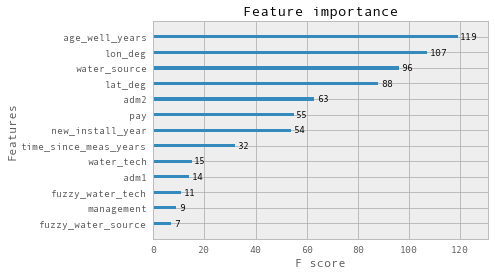

In [35]:
#retrain with best params for feature importances
best_modelB = XGBClassifier(params= modelB.best_params_)
#refit
best_modelB.fit(X_test, y_test)
xgb.plot_importance(best_modelB)

# Now we store the results that have the correct indices, so we can merge back with our original dataframe

In [42]:
#for model B
train_results={'status_binary':y_train, 'predicted_class':predsB_accuracy, 'probability':predsB_AUC}
train_results_df=pd.DataFrame(data=train_results)
train_results_df
#pd.merge(df2, pd.DataFrame(data=d))

,predicted_class,probability,status_binary
323423,0,0.069016,0
317602,0,0.007976,0
319878,1,0.887806,1
304919,0,0.272604,1
315928,1,0.857971,1
313692,1,0.969989,1
317628,0,0.007976,0
309644,0,0.001352,0
323321,1,0.991152,1
315760,0,0.004507,0


In [43]:
#results for model A
test_results={'status_binary':y_test, 'predicted_class':predsA_accuracy, 'probability':predsA_AUC}
test_results_df=pd.DataFrame(data=test_results)
test_results_df



,predicted_class,probability,status_binary
301788,0,0.008553,0
322296,1,0.805480,1
317168,0,0.014261,0
322173,1,0.806242,1
311988,0,0.044204,0
305743,0,0.000105,0
305958,0,0.020035,0
310549,0,0.000585,0
307281,0,0.000073,0
316503,0,0.070475,0


In [44]:
#concat the preditions from the two models
df_results= pd.concat([train_results_df, test_results_df])
#check the length of the index to ensure we have the correct number of values
len(df_results.index.unique())

23784

In [45]:
#double check against the original swaziland index length
len(df2.index.unique())

23784

In [52]:
#merge our results with our original data frame for swaziland
swaz_results = pd.merge(df_dict['Swaziland'], df_results, left_index=True, right_index=True)

In [53]:
#if this is not zero it means that we merged incorrectly. Status_binary_x is from the original data frame, 
#status_binary_y is from the one we just merged in...they should exactly line up.
#they do
sum(swaz_results.status_binary_x != swaz_results.status_binary_y)

0

In [54]:
# find wells where we predicted failure but it's not showing failure
pred_bad_wells = swaz_results.loc[(swaz_results.predicted_class ==1) & (swaz_results.predicted_class != swaz_results.status_binary_x)]
pred_bad_wells.shape

(192, 42)

In [55]:
pred_bad_wells

,country_name,water_source,water_tech,status_id,management,pay,installer,install_year,status,source,adm1,adm2,wpdx_id,report_date,country_id,activity_id,data_lnk,orig_lnk,photo_lnk,converted,created,updated,lat_deg,lon_deg,Location,Count,fecal_coliform_presence,fecal_coliform_value,subjective_quality,new_report_date,new_install_year,age_well,age_well_days,status_binary_x,time_since_measurement,time_since_meas_years,age_well_years,fuzzy_water_source,fuzzy_water_tech,predicted_class,probability,status_binary_y
301874,Swaziland,Borehole fitted with manual pump,Borehole,yes,Community Management,5,__MISSING__,2004.0,__MISSING__,Swaziland Department of Water Affairs,SHISELWENI,SIGWE,wpdx-00472433,06/05/2015 12:00:00 AM +0000,SZ,SZ0:11:00 AM40008,__MISSING__,https://www.waterpointdata.org/dataset/resourc...,__MISSING__,#status_id; #report_date; #management; #instal...,01/19/2017 06:11:38 AM +0000,01/19/2017 06:11:38 AM +0000,-2.711420e+01,31.6735,"(-27.1142, 31.6735)",1,NaN,NaN,NaN,2015-06-05,2004-01-01 00:00:00,4173 days 00:00:00.000000000,4173,0,1002 days 00:00:00.000000000,2.7,11.4,Borehole,Borehole,1,0.702422,0
301887,Swaziland,Borehole,Borehole,yes,Institutional Management,0,__MISSING__,2007.0,__MISSING__,Swaziland Department of Water Affairs,SHISELWENI,SIGWE,wpdx-00472446,06/05/2015 12:00:00 AM +0000,SZ,SZ0:12:00 AM20007,__MISSING__,https://www.waterpointdata.org/dataset/resourc...,__MISSING__,#status_id; #report_date; #management; #instal...,01/19/2017 06:12:02 AM +0000,01/19/2017 06:12:02 AM +0000,-2.711300e+01,31.6762,"(-27.113, 31.6762)",1,NaN,NaN,NaN,2015-06-05,2007-01-01 00:00:00,3077 days 00:00:00.000000000,3077,0,1002 days 00:00:00.000000000,2.7,8.4,Borehole,Borehole,1,0.651816,0
302047,Swaziland,Borehole fitted with manual pump,Borehole,yes,Community Management,0,__MISSING__,2007.0,__MISSING__,Swaziland Department of Water Affairs,SHISELWENI,SIGWE,wpdx-00472604,06/05/2015 12:00:00 AM +0000,SZ,SZ0:24:00 AM30007,__MISSING__,https://www.waterpointdata.org/dataset/resourc...,__MISSING__,#status_id; #report_date; #management; #instal...,01/19/2017 06:13:12 AM +0000,01/19/2017 06:13:12 AM +0000,-2.709870e+01,31.6641,"(-27.0987, 31.6641)",1,NaN,NaN,NaN,2015-06-05,2007-01-01 00:00:00,3077 days 00:00:00.000000000,3077,0,1002 days 00:00:00.000000000,2.7,8.4,Borehole,Borehole,1,0.616711,0
302164,Swaziland,Borehole fitted with manual pump,Borehole,yes,Community Management,0,__MISSING__,1987.0,__MISSING__,Swaziland Department of Water Affairs,SHISELWENI,GEGE,wpdx-00472719,07/07/2015 12:00:00 AM +0000,SZ,SZ0:33:00 AM40034,__MISSING__,https://www.waterpointdata.org/dataset/resourc...,__MISSING__,#status_id; #report_date; #management; #instal...,01/19/2017 06:13:58 AM +0000,01/19/2017 06:13:58 AM +0000,-2.690110e+01,31.0005,"(-26.9011, 31.0005)",1,NaN,NaN,NaN,2015-07-07,1987-01-01 00:00:00,10414 days 00:00:00.000000000,10414,0,970 days 00:00:00.000000000,2.7,28.5,Borehole,Borehole,1,0.776434,0
302187,Swaziland,Borehole fitted with submersible pump,Borehole,yes,Institutional Management,0,__MISSING__,2015.0,__MISSING__,Swaziland Department of Water Affairs,SHISELWENI,SHISELWENI II,wpdx-00472742,06/25/2015 12:00:00 AM +0000,SZ,SZ0:35:00 AM100010,__MISSING__,https://www.waterpointdata.org/dataset/resourc...,__MISSING__,#status_id; #report_date; #management; #instal...,01/19/2017 06:13:58 AM +0000,01/19/2017 06:13:58 AM +0000,-2.703140e+01,31.2955,"(-27.0314, 31.2955)",1,NaN,NaN,NaN,2015-06-25,2015-01-01 00:00:00,175 days 00:00:00.000000000,175,0,982 days 00:00:00.000000000,2.7,0.5,Borehole,Borehole,1,0.677915,0
302325,Swaziland,Borehole fitted with submersible pump,Borehole,yes,Institutional Management,0,__MISSING__,1999.0,__MISSING__,Swaziland Department of Water Affairs,LUBOMBO,SIPHOFANENI,wpdx-00472879,07/17/2015 12:00:00 AM +0000,SZ,SZ0:46:00 AM120124,__MISSING__,https://www.waterpointdata.org/dataset/resourc...,__MISSING__,#status_id; #report_date; #management; #instal...,01/19/2017 06:15:09 AM +0000,01/19/2017 06:15:09 AM +0000,-2.6

In [56]:
sum(swaz_results.index == df_dict['Swaziland'].index)

23784

In [57]:
swaz_results.to_csv('swaziland_with_preds.csv')

# To Do- Clean this up and make a function to run for all countries

In [ ]:
def predict_df(df):
    """args: Pandas Dataframe
       1) label encodes all variables, and stores the inverse transforms in a dictionary
       2) Does stratified train/test split on each country
       3) Uses Grid Search on training data
       4) Takes parameters from best model, calculates AUC/ Accuracy
       returns:
       1) Dictionary of label encoded variables and their inverse (I hope)
       2) XGBoost model object with the best model"""
    df2 = df.copy()
    
    #only keep prediction columns
    pred_cols = ['water_source', 'water_tech', 'management',
       'source', 'adm1', 'adm2', 'pay', 'lat_deg', 'lon_deg',
       'new_install_year', 'age_well_years','time_since_meas_years', 'fuzzy_water_source',
        'fuzzy_water_tech','status_binary']

    df2=df2[pred_cols]

    #convert all fields to int labels for the classifier
    lb=LabelEncoder() #instantiate label encoder

    #create a dict to store our inverse transforms...these allow us to convert back to the original values in our data
    from collections import defaultdict
    d = defaultdict(LabelEncoder)

    # Encoding each variable
    fit = df2.apply(lambda x: d[x.name].fit_transform(x))

    # Inverse the encoded
    inverse = fit.apply(lambda x: d[x.name].inverse_transform(x))
    
    #define features and target columns
    X = fit[fit.columns[:-1]] 
    Y= fit.status_binary
    
    #Create 50% test sets, 50% training, stratifying on Y.
    #We we will train and make predictions on the other half, then swithch
    X_train, X_test, y_train, y_test = model_selection.train_test_split(X, Y,  test_size=.5, random_state=7, stratify=Y)
    
    #use stratified K folds and gridsearch..ON THE TRAINING DATA
    params = {'learning_rate':[0.05,.1], 'max_depth':[3,4], 'n_estimators':[200,300],}
    modelA = model_selection.GridSearchCV(XGBClassifier(scoring='logloss'), params)
    modelA.fit(X_train, y_train )
    print('model fit for first 50% of', df.country_name.unique())
    print(modelA.best_params_)
    #print(model2.grid_scores_)
    print(modelA.best_score_)
    
    
    #get auc. need to reshape
    predsA_AUC = modelA.predict_proba(X_test)[:,1]
    predsA_accuracy = modelA.predict(X_test)
    print("Accuracy for modelA : %.4g"%metrics.accuracy_score(y_test, predsA_accuracy))
    print("AUC Score (test) for modelA: %f"%metrics.roc_auc_score(y_test, predsA_AUC))
    
   
    
    # calculate the fpr and tpr for all thresholds of the classification
    fpr, tpr, threshold = metrics.roc_curve(y_test, predsA_AUC)
    roc_auc = metrics.auc(fpr, tpr)

    # method I: plt
    import matplotlib.pyplot as plt
    
    plt.title('ROC Curve - GradBoosted Trees')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
    #retrain with best params for feature importances
    best_modelA = XGBClassifier(params= modelA.best_params_)
    #refit
    best_modelA.fit(X_train, y_train)
    #plot feature importance
    #%matplotlib inline
    #xgb.plot_importance(best_model)
    
#     trees = model2.best_params_['n_estimators']
#     lr = model2.best_params_['learning_rate']
#     depth = model2.best_params_['max_depth']
#     #retrain to get partial dependence
#     clf = GradientBoostingClassifier(learning_rate=lr, n_estimators=trees, max_depth=depth).fit(X_train, y_train)    
  
    ###################REPEAT FOR SECOND 50%##########################
     #use stratified K folds and gridsearch..ON THE TRAINING DATA
    params = {'learning_rate':[0.05,.1], 'max_depth':[3,4], 'n_estimators':[200,300],}
    modelB = model_selection.GridSearchCV(XGBClassifier(scoring='logloss'), params)
    modelB.fit(X_test, y_test )
    print('model fit for second 50% of', df.country_name.unique())
    print(modelB.best_params_)
    #print(model2.grid_scores_)
    print(modelB.best_score_)
    
    
    #get auc. need to reshape
    predsB_AUC = modelB.predict_proba(X_train)[:,1]
    predsB_accuracy = modelB.predict(X_train)
    print("Accuracy for modelB : %.4g"%metrics.accuracy_score(y_train, predsB_accuracy))
    print("AUC Score (test) for modelB: %f"%metrics.roc_auc_score(y_train, predsB_AUC))
    
   

#     fpr2, tpr2, threshold = metrics.roc_curve(y_test, predsA_AUC)
#     roc_auc = metrics.auc(fpr, tpr)

#     # method I: plt
#     import matplotlib.pyplot as plt
    
#     plt.title('ROC Curve - GradBoosted Trees')
#     plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
#     plt.legend(loc = 'lower right')
#     plt.plot([0, 1], [0, 1],'r--')
#     plt.xlim([0, 1])
#     plt.ylim([0, 1])
#     plt.ylabel('True Positive Rate')
#     plt.xlabel('False Positive Rate')
#     plt.show()
    
    #retrain with best params for feature importances
    best_modelB = XGBClassifier(params= modelB.best_params_)
    #refit
    best_modelB.fit(X_test, y_test)
    
    #append predictions to dataset
    X_test['predicted_class']=predsA_accuracy
    X_test['predicted_prob'] =predsA_AUC
    X_train['predicted_class']=predsB_accuracy
    X_train['predicted_prob'] =predsB_AUC
    
    finaldf = X_train.merge(X_test)
    print(finaldf.head())
    finaldf= finaldf.apply(lambda x: d[x.name].inverse_transform(x))
    print(finaldf.head())
    print
    
    
    return best_modelA,best_modelB, finaldf

In [ ]:
swaz_modelA, swaz_modelB, swaz_final_df = predict_df(df_dict['Swaziland'])

In [32]:
xgb.plot_importance(swaz_modelA)

NameError: name 'swaz_modelA' is not defined

In [ ]:
xgb.plot_importance(swaz_modelB)

In [ ]:
#now that predictions are ran, convert X_train back to normal
X_train = X_train.apply(lambda x: d[x.name].inverse_transform(x))
#same with X_test 
X_test = X_test.apply(lambda x: d[x.name].inverse_transform(x))

In [ ]:
#append predictions to dataset
X_test['predicted_class']=predsA_accuracy
X_test['predicted_prob'] =predsA_AUC
X_test['status_binary'] = y_test
X_train['predicted_class']=predsB_accuracy
X_train['predicted_prob'] =predsB_AUC
X_train['status_binary']=y_train